Hello there! I’m Maria, and I like transforming famous quantum thought experiments into quantum circuits using Qiskit. For the latest instalment of our Quantum Paradoxes content series, we’re taking a look at a quantum version of a well-known thought experiment from the classical realm—Maxwell’s Demon.

In this notebook, I will show you how to take a refinement of the Maxwell’s Demon thought experiment known as Szilard’s Engine, and implement it as a quantum circuit. To learn why we’re interested in doing this, <b>be sure to check out the [Qiskit blog](https://medium.com/qiskit) that accompanies this notebook</b>. The blog also provides a basic overview of the original Maxwell’s Demon thought experiment, and tells the story of how physicist Leo Szilard shrank it down to the quantum scale with his Szilard’s Engine.

In this notebook, we’ll be taking the original Szilard’s engine—which is technically rooted in classical physics—and see what happens when we apply the laws of quantum mechanics. But before we get started turning demons into qubits, let’s go over the basic premise of Szilard’s Engine once more for those who did not read the [Qiskit blog](https://medium.com/qiskit) (though you really should!). 

If you’ve already read the blog, you can skip down to the next section of this notebook, [<b> “Quantum Szilard’s Engine.” </b>](#Quantum_Szilard_Engine). And if you haven’t already, don’t forget to check out [my video](https://youtu.be/YX5VxYvDfxM) about Maxwell’s Demon on the [Qiskit YouTube channel](https://www.youtube.com/c/qiskit).

## Szilard’s Engine Recap

Szilard’s Engine presents us with a box containing a single particle moving randomly. A demon inserts a partition in the middle of the box, and that partition acts like a moving wall. Its resting place is in the centre of the box, but if you push on its left side, it will move to the right, making the right side of the box smaller—and vice versa. 

After the demon inserts the partition, it measures whether the particle is on the left or right, storing this information in its memory. If the particle is on the left, for example, the demon attaches a weight to the left side of the partition. It helps to imagine that this weight hangs on a string, and the string is attached to the partition wall by a pulley system, such that if you push the partition to the right, the weight will move up in the air. 

Neither the weight nor the partition is terribly heavy, so the single particle can push the partition and lift the weight with only the force of its random movements. Once the movement of the particle causes the weight to lift, we can say the demon has effectively used information about the particle to extract useful energy from the particle’s random behaviour. The movement of the weight shows us how much energy we were able to extract.

But is this a violation of the second law of thermodynamics? 

Well, not quite. To repeat this energy extraction, the demon must erase its memory. The Landauer principle tells us that memory erasure has a minimum entropy cost to the environment, which compensates for the decrease in entropy that the demon gained from using information about the particle’s position. With a blank memory and a randomly moving particle once more, the cycle can repeat.

For more background on the demon’s memory and Landauer's principle, be sure to read the [Qiskit blog](https://medium.com/qiskit) and watch the [video](https://youtu.be/YX5VxYvDfxM).

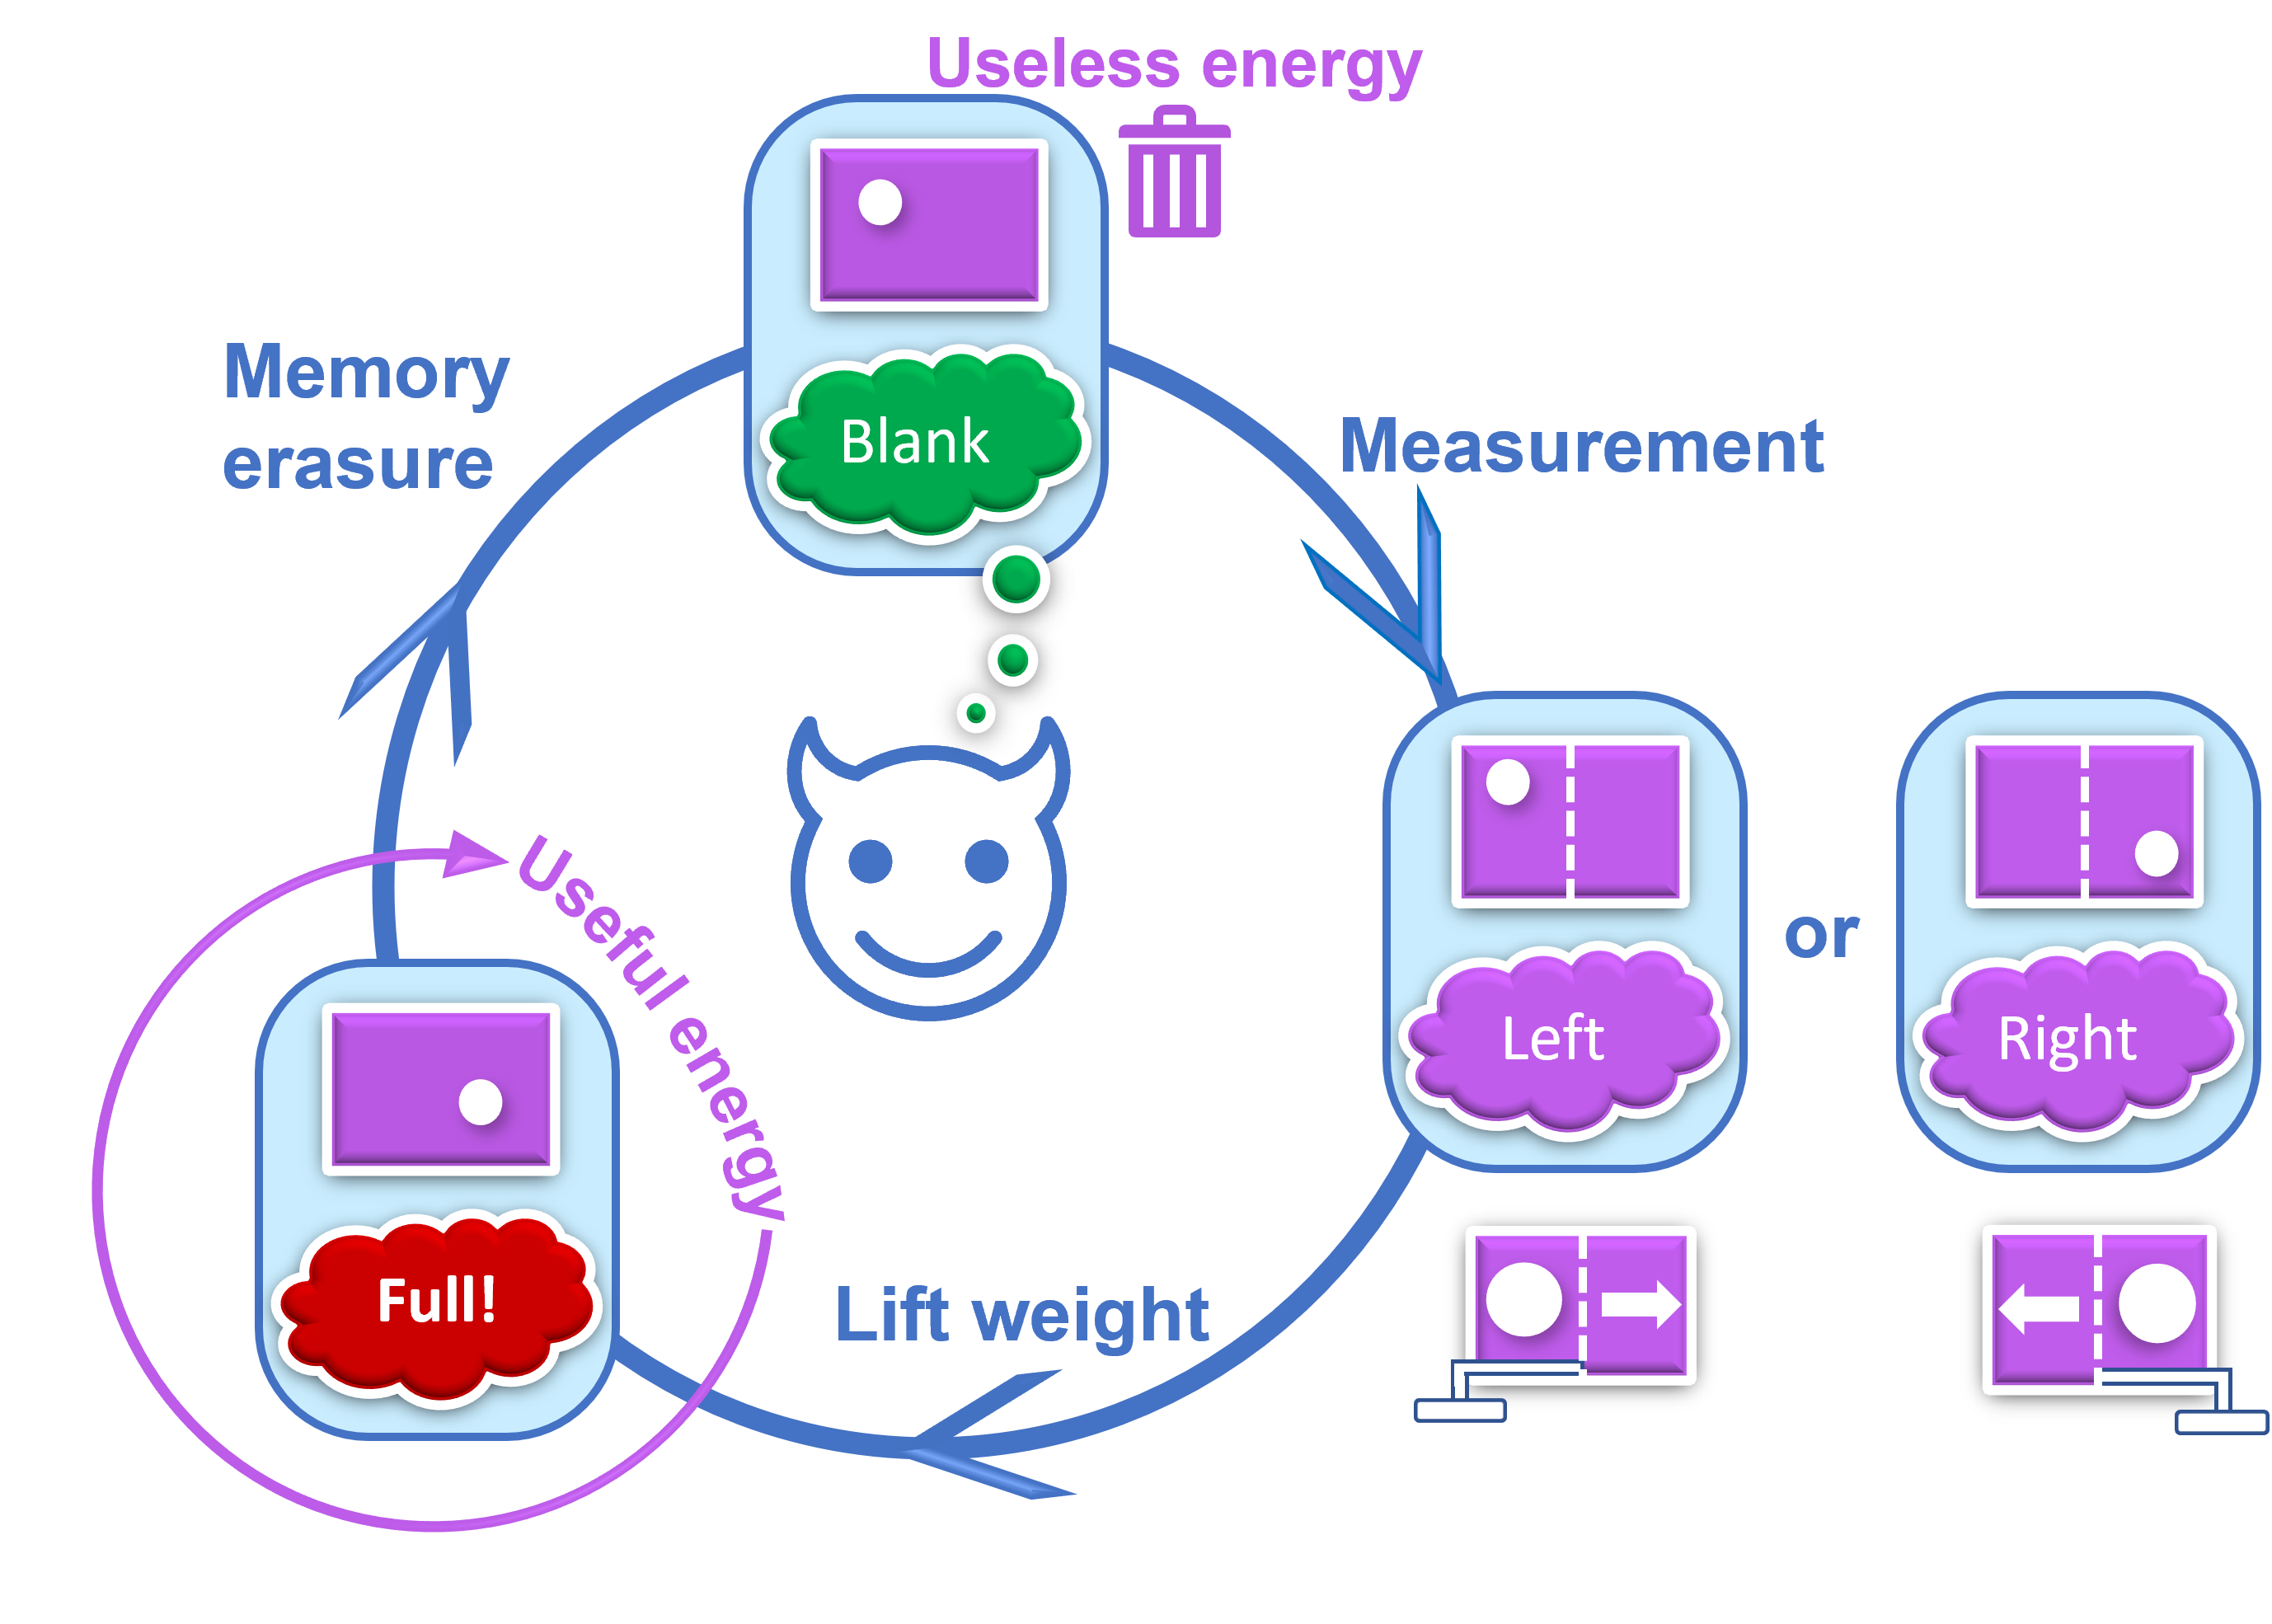

Note the importance of the demon’s memory. If it is faulty, the demon may attach the weight to the wrong side of the partition, and then the particle expanding into the box would lower the weight instead of lifting it, meaning the demon loses useful energy instead of gaining it. If the demon’s memory was not erased, then it would be correct half the time (lift the weight) and wrong half the time (lower the weight), so on average no useful energy could be extracted from the box.

<a id='Quantum_Szilard_Engine'></a>
## Quantum Szilard's Engine

The original Szilard’s engine shows us what happens when we convert Maxwell’s Demon to a microscopic system, that doesn’t make it quantum. Szilard assumed his single particle behaves classically, so the original Szilard’s engine doesn’t tell us if the paradox still holds when we apply the laws of quantum mechanics. 

To build a quantum Szilard’s engine, we need to create a set-up where every element of the system we’re looking at obeys the laws of quantum mechanics. In other words, we need to make it so that all interactions between the demon, the particle, the weight, and the environment are <b>unitary</b>, meaning the interactions must all be reversible (although we’ll soon see that our quantum circuit version will make use of some convenient non-unitary operations in Qiskit.)

Fortunately, thanks to quantum computers, we don’t have to dream up an entriely new demonic thought experiment to do this . We’ll just encode Szilard’s engine as a quantum circuit.

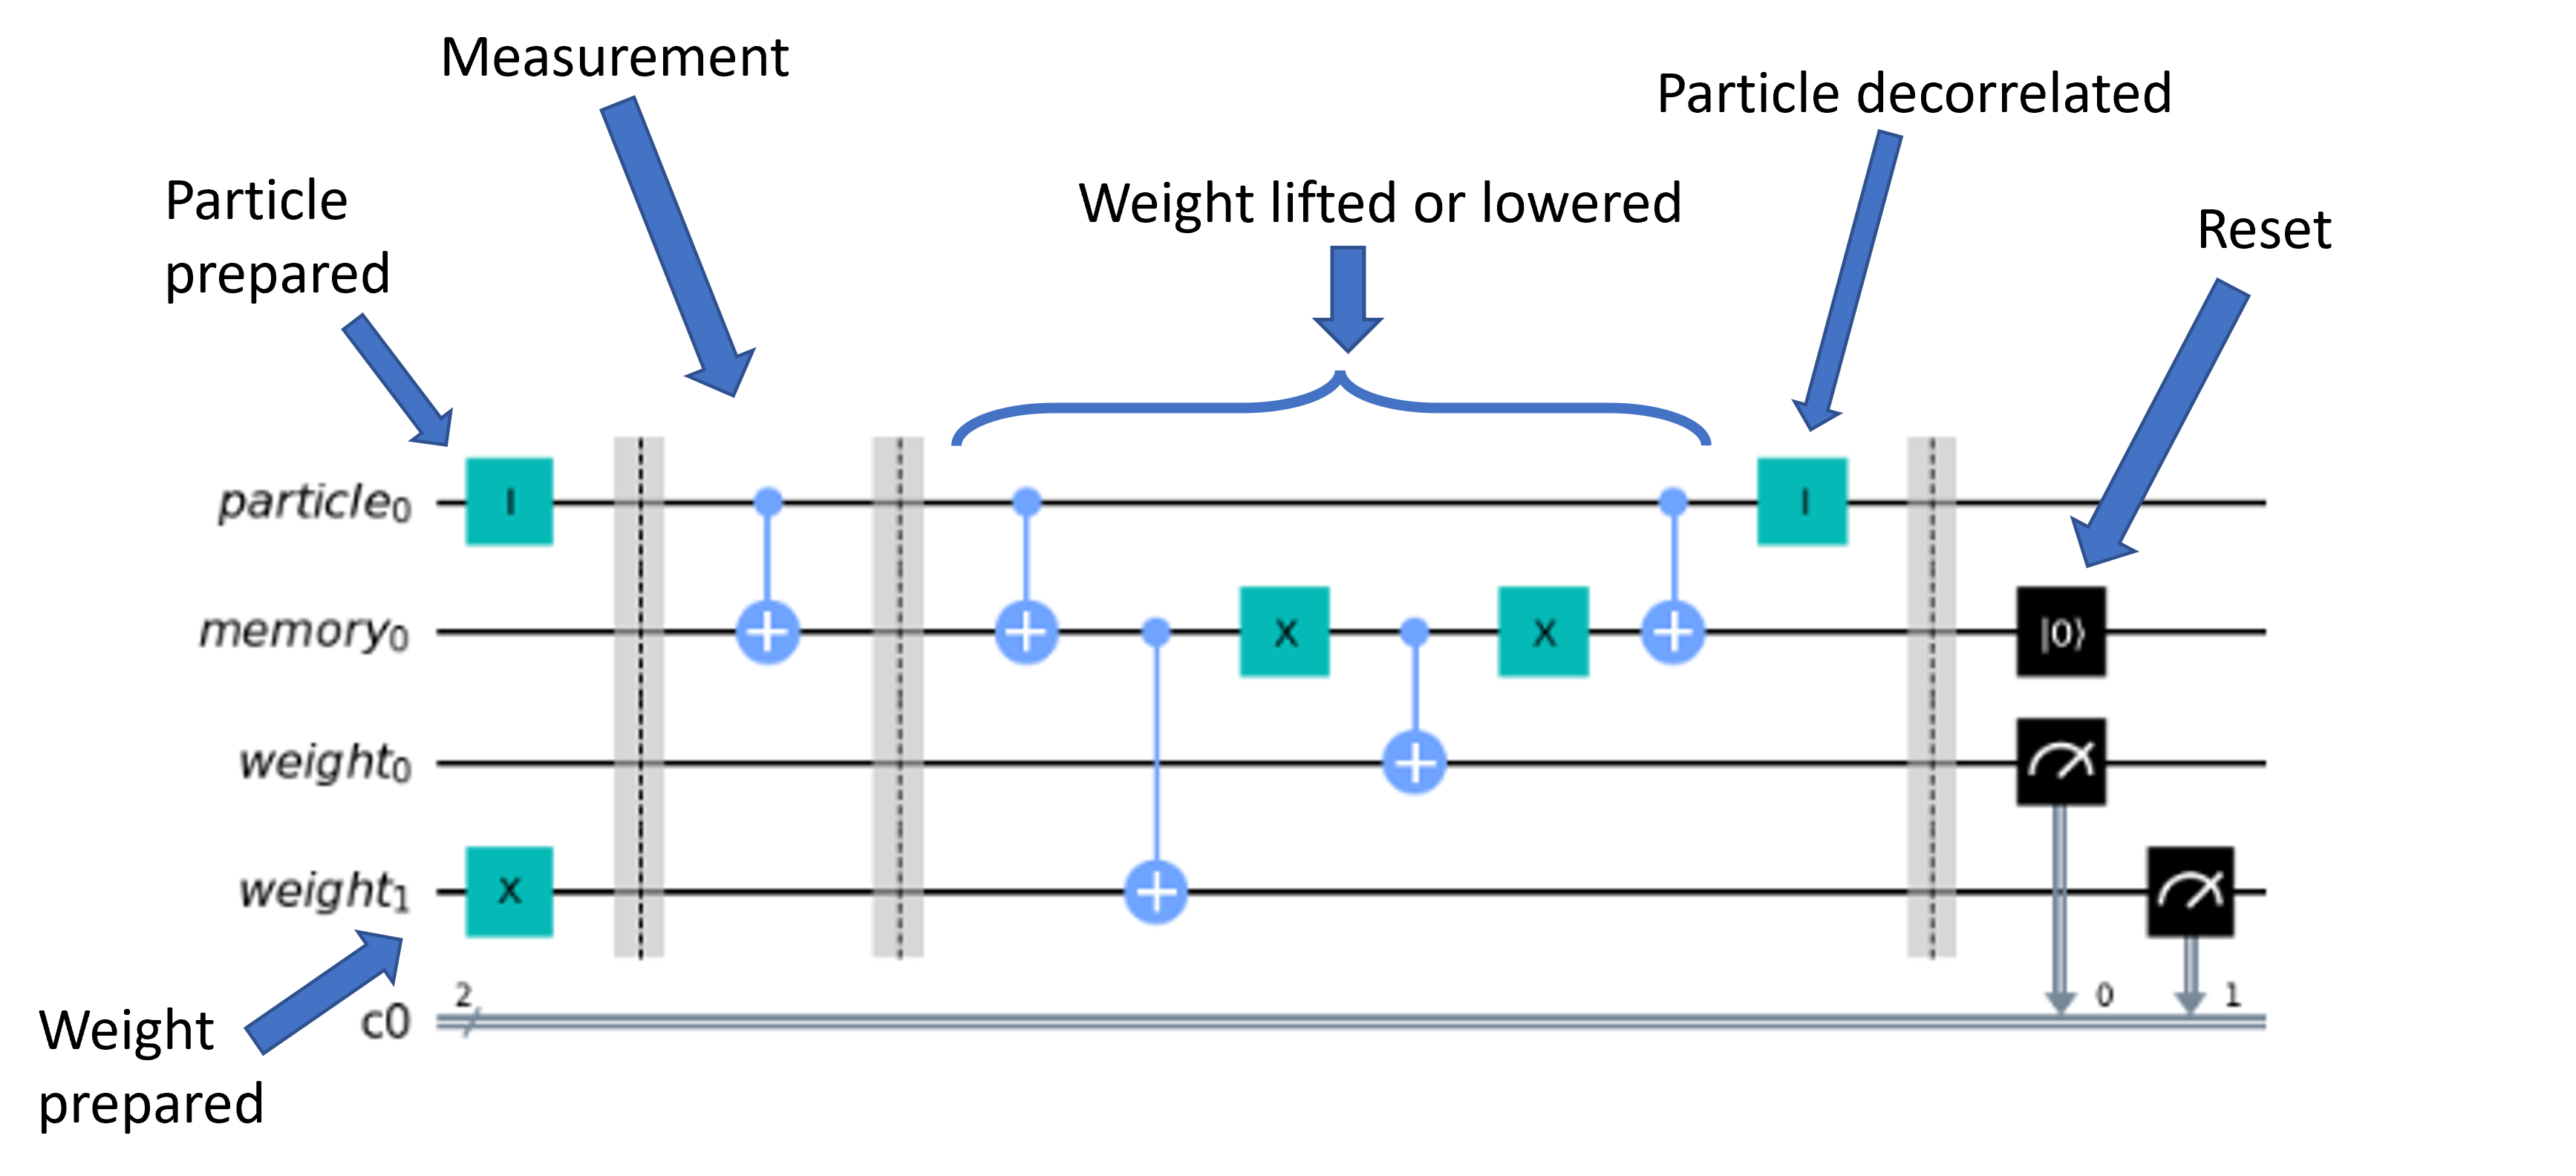

We can model the particle randomly moving in the box as a qubit in a maximally mixed state—meaning the qubit has half probability of being measured as 0, and half probability of being measured as 1, independently of which basis we measure it in. This is different to a superposition state, such as |+⟩, which gives a definite outcome if measured in the x basis. 

One way to prepare a maximally mixed state is to flip a coin, and prepare |0⟩ if it is Heads, and |1⟩ if it is Tails. In Qiskit I used a noisy Identity gate to prepare the particle qubit in a random state. I am representing the <b>Left</b> side of the box with |0⟩, and the <b>Right</b> side of the box with |1⟩.

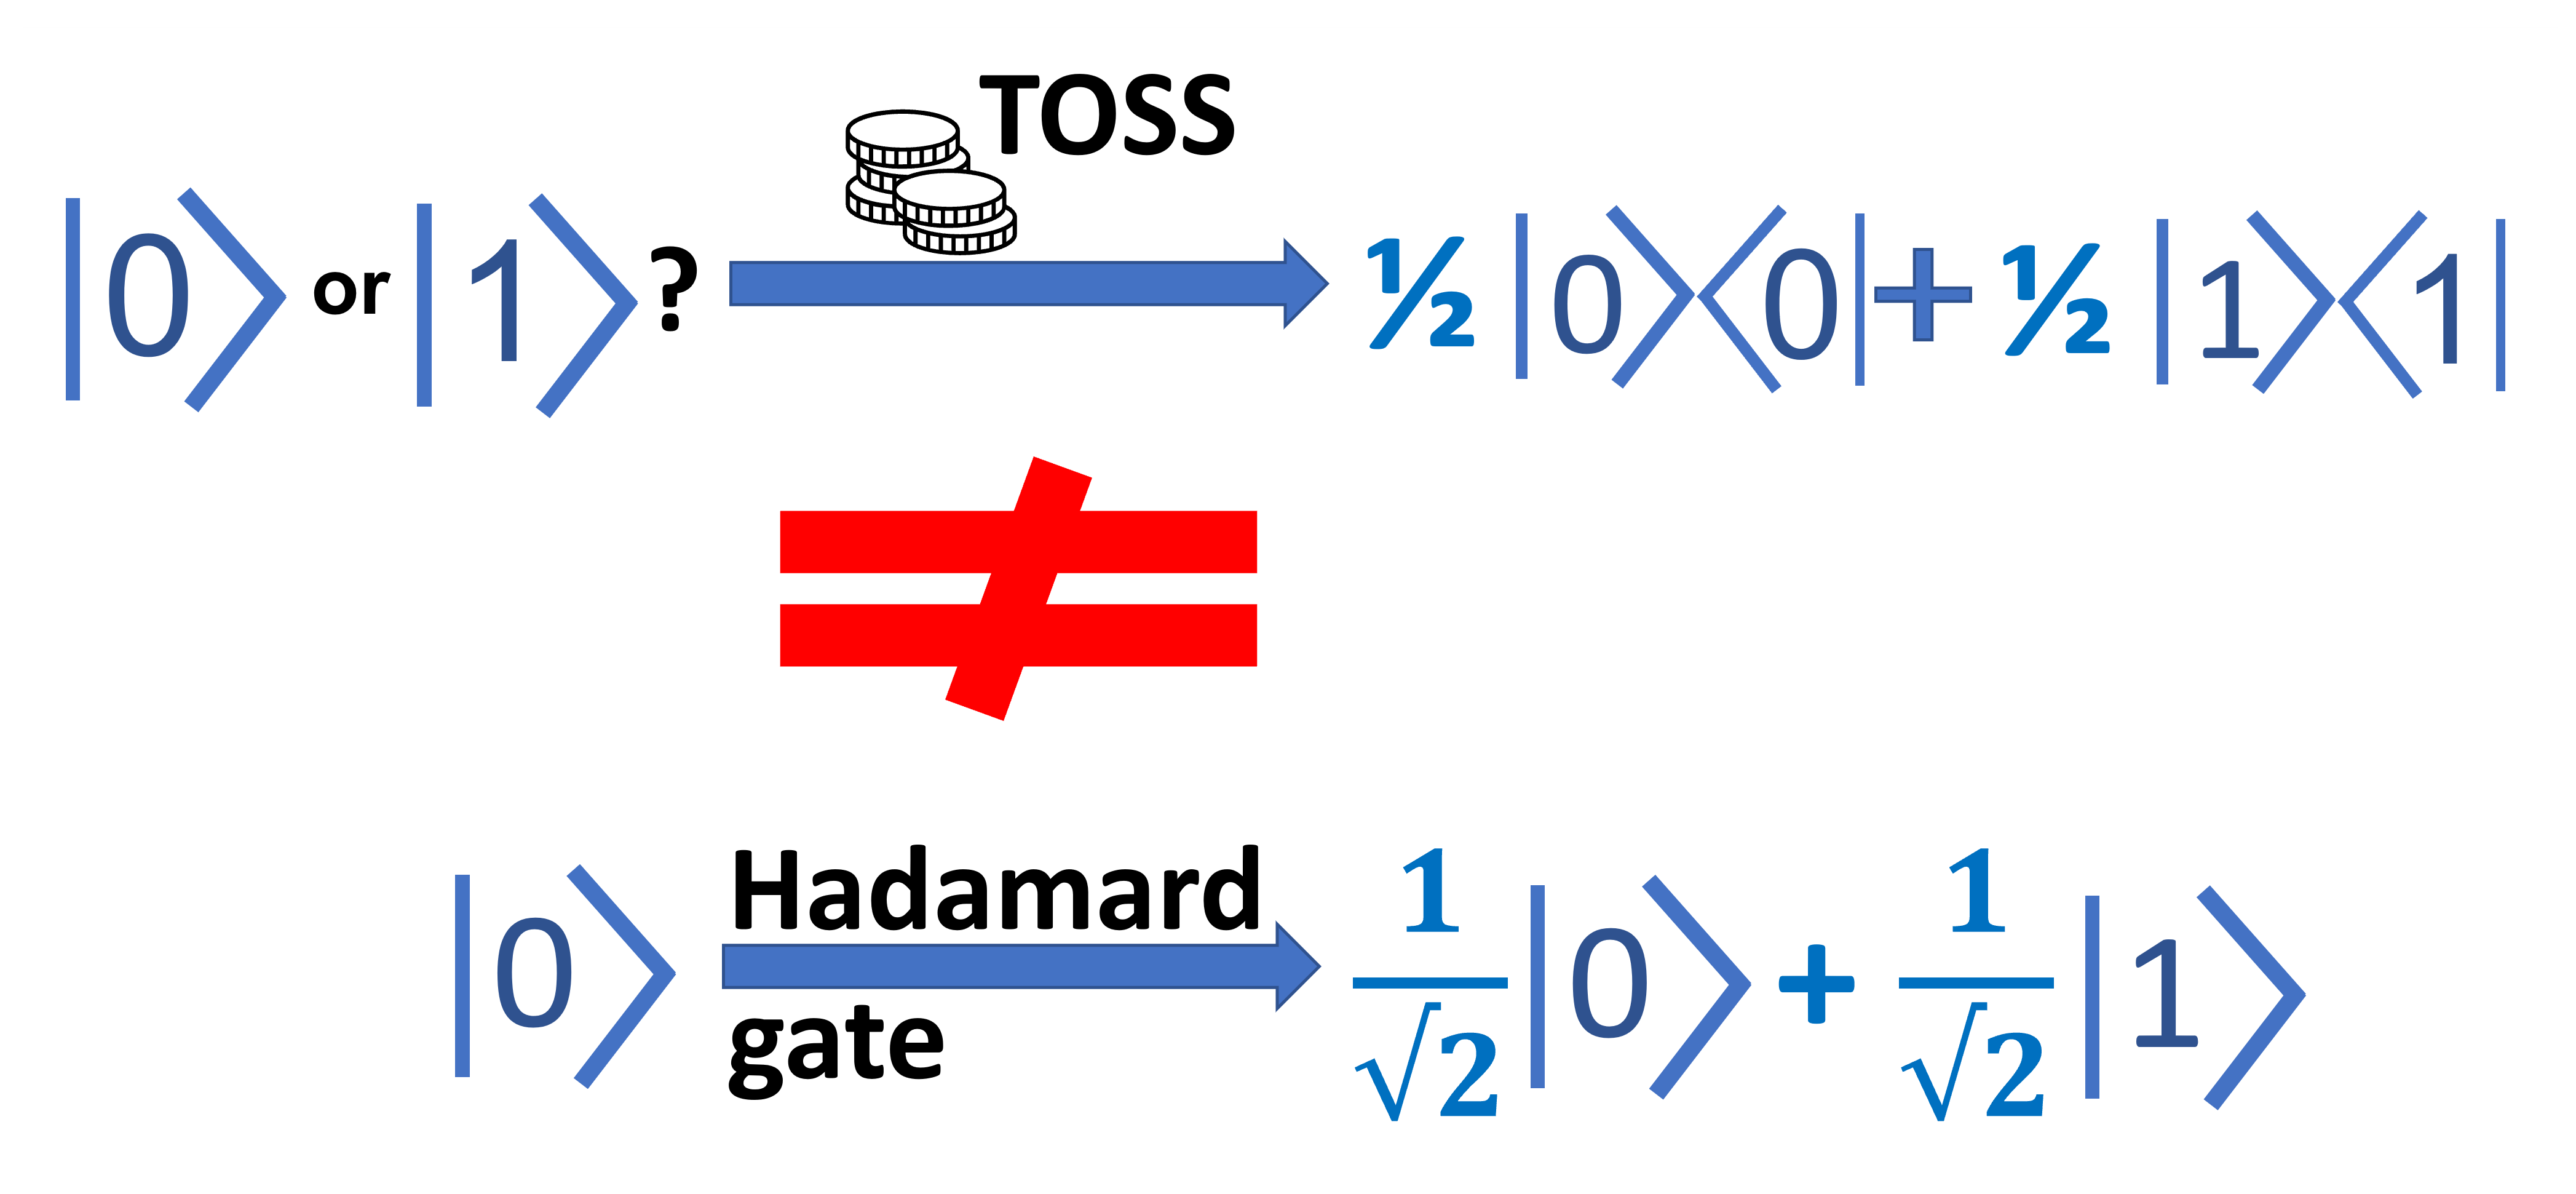

The demon’s memory starts off as a blank |0⟩ state. The demon’s measurement of which side the particle is in is equivalent to performing a CNOT gate, controlled on the particle and targeted on the demon’s memory. If the particle is |0⟩, the demon’s memory stays as |0⟩, indicating the particle is on the left. If the particle is |1⟩, the demon’s memory is flipped to |1⟩, indicating the particle is on the right. 

Now if the demon’s memory is correct, it needs to lift the weight, and if it is wrong, it needs to lower the weight. To have a weight that can be in at least three states (middle, lifted and lowered), my quantum weight is made of two qubits. The joint state |01⟩ is the starting position, |00⟩ is the low energy state where the weight is lowered, and |11⟩ is the high energy state where the weight is lifted. 

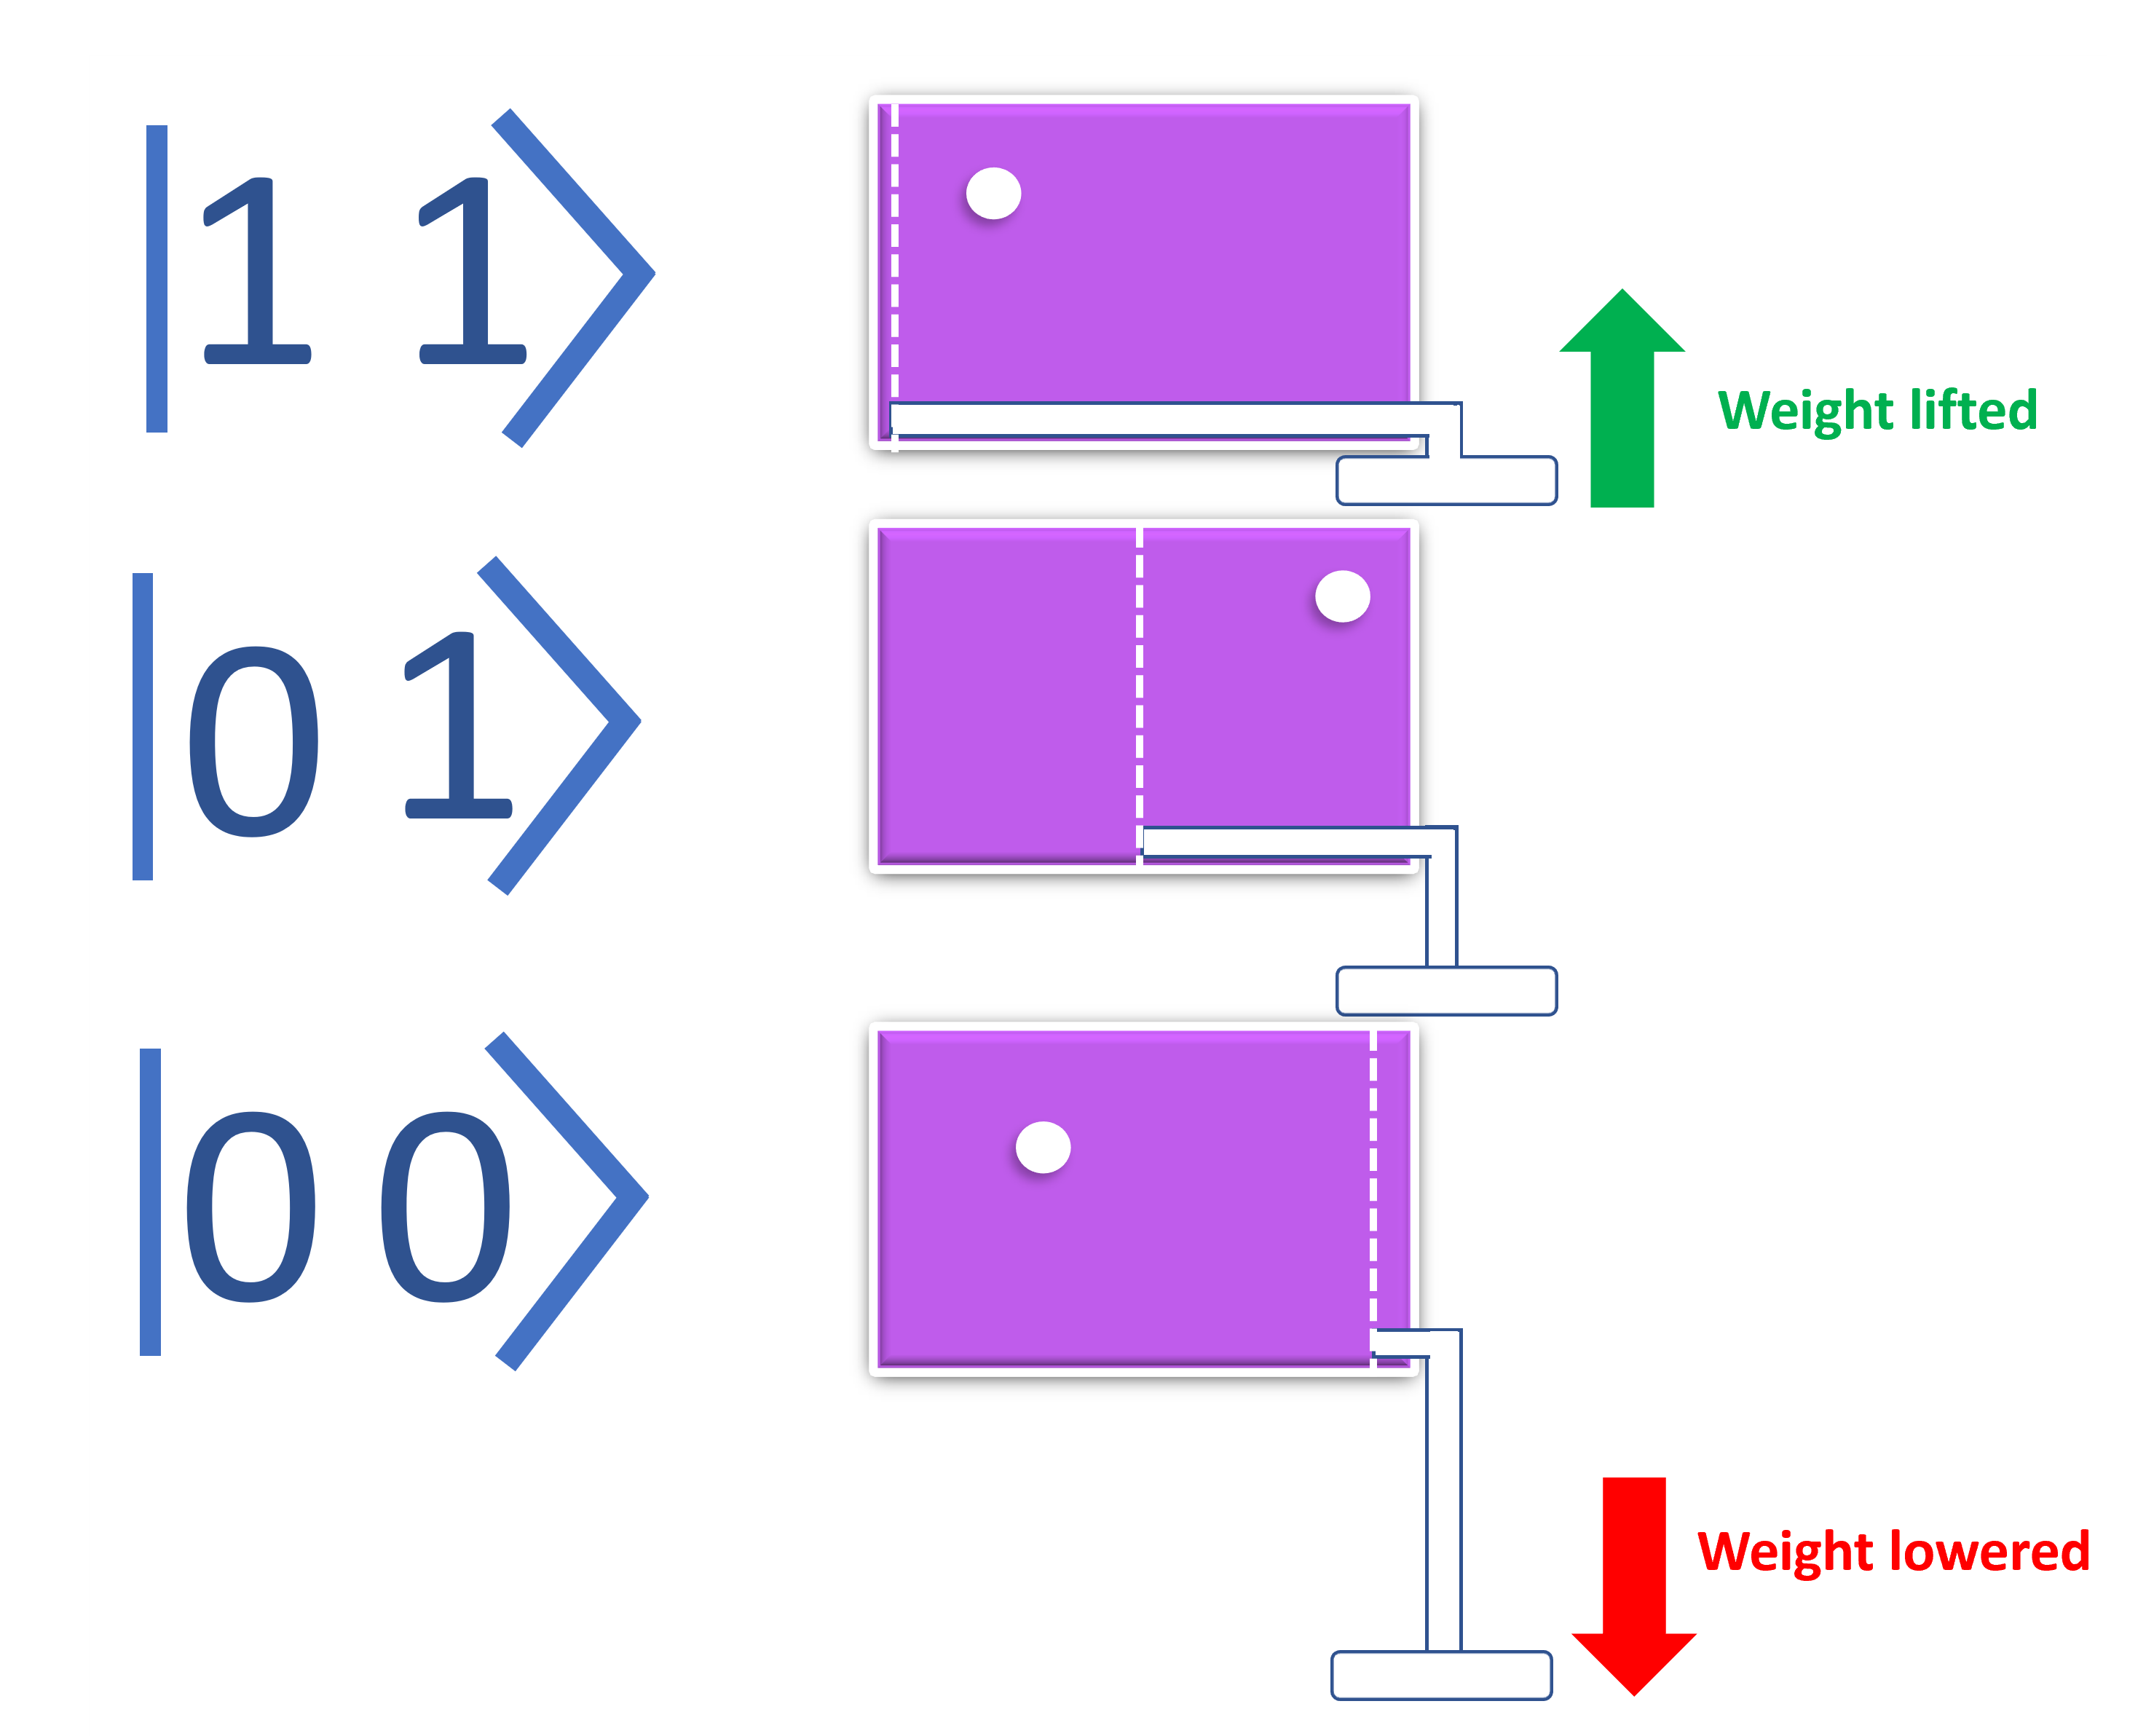

To manage the demon’s memory, we can use a chain of CNOT and X gates that flips the first weight qubit to 1 (lifts weight) if the demon’s memory and particle state are the same, and flips the second weight qubit to 0 (lowers weight) if the demon’s memory and particle state are different. 

When the memory starts off in a blank |0⟩ state, the demon’s memory is always correct and the weight is lifted. After this, the particle’s position becomes decorrelated from the demon’s memory and the weight, and is randomly moving around again, back in a maximally mixed state. I used another noisy Identity gate to decorrelate the particle. Then, the demon’s memory qubit also ends up in a maximally mixed state. 

If we attempt to use this full memory qubit to run the cycle again, it will not work: The demon cannot reliably measure the state of the particle, and half the time the weight will be lifted, half the time it will be lowered. To repeat the cycle, we need to erase the demon’s memory, which we can do using the reset operation in Qiskit.  

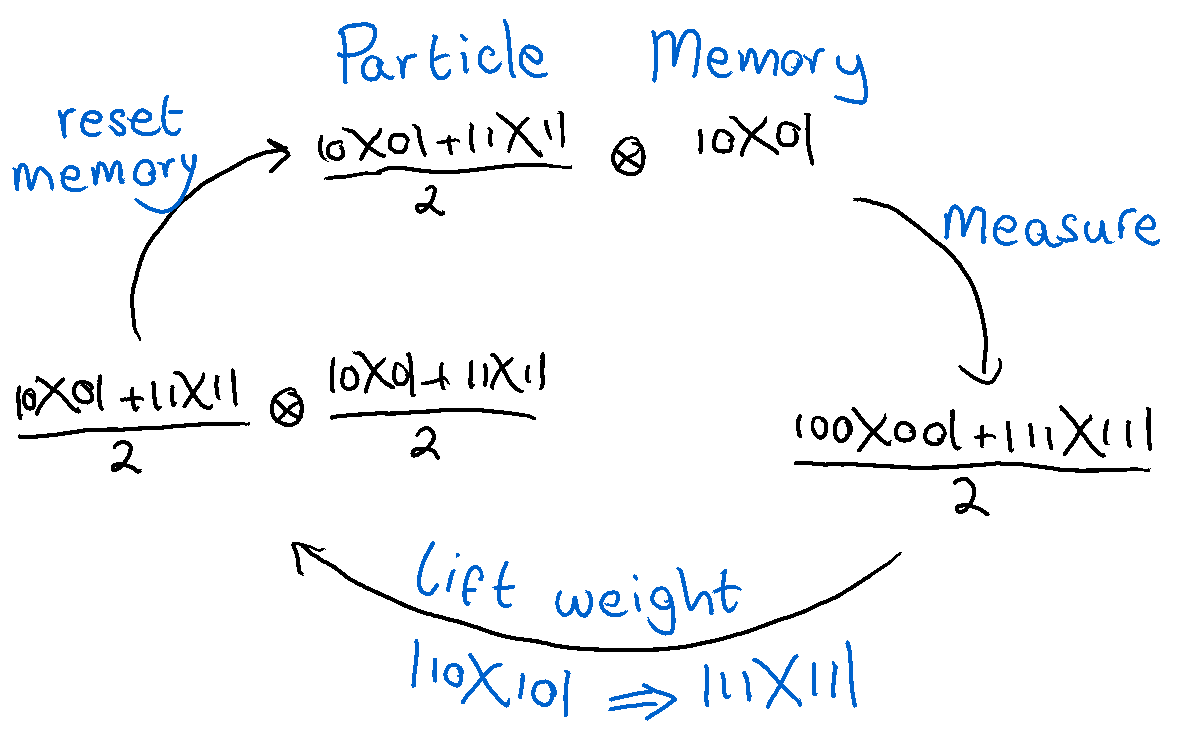

That completes our Szilard engine cycle as a quantum circuit! 

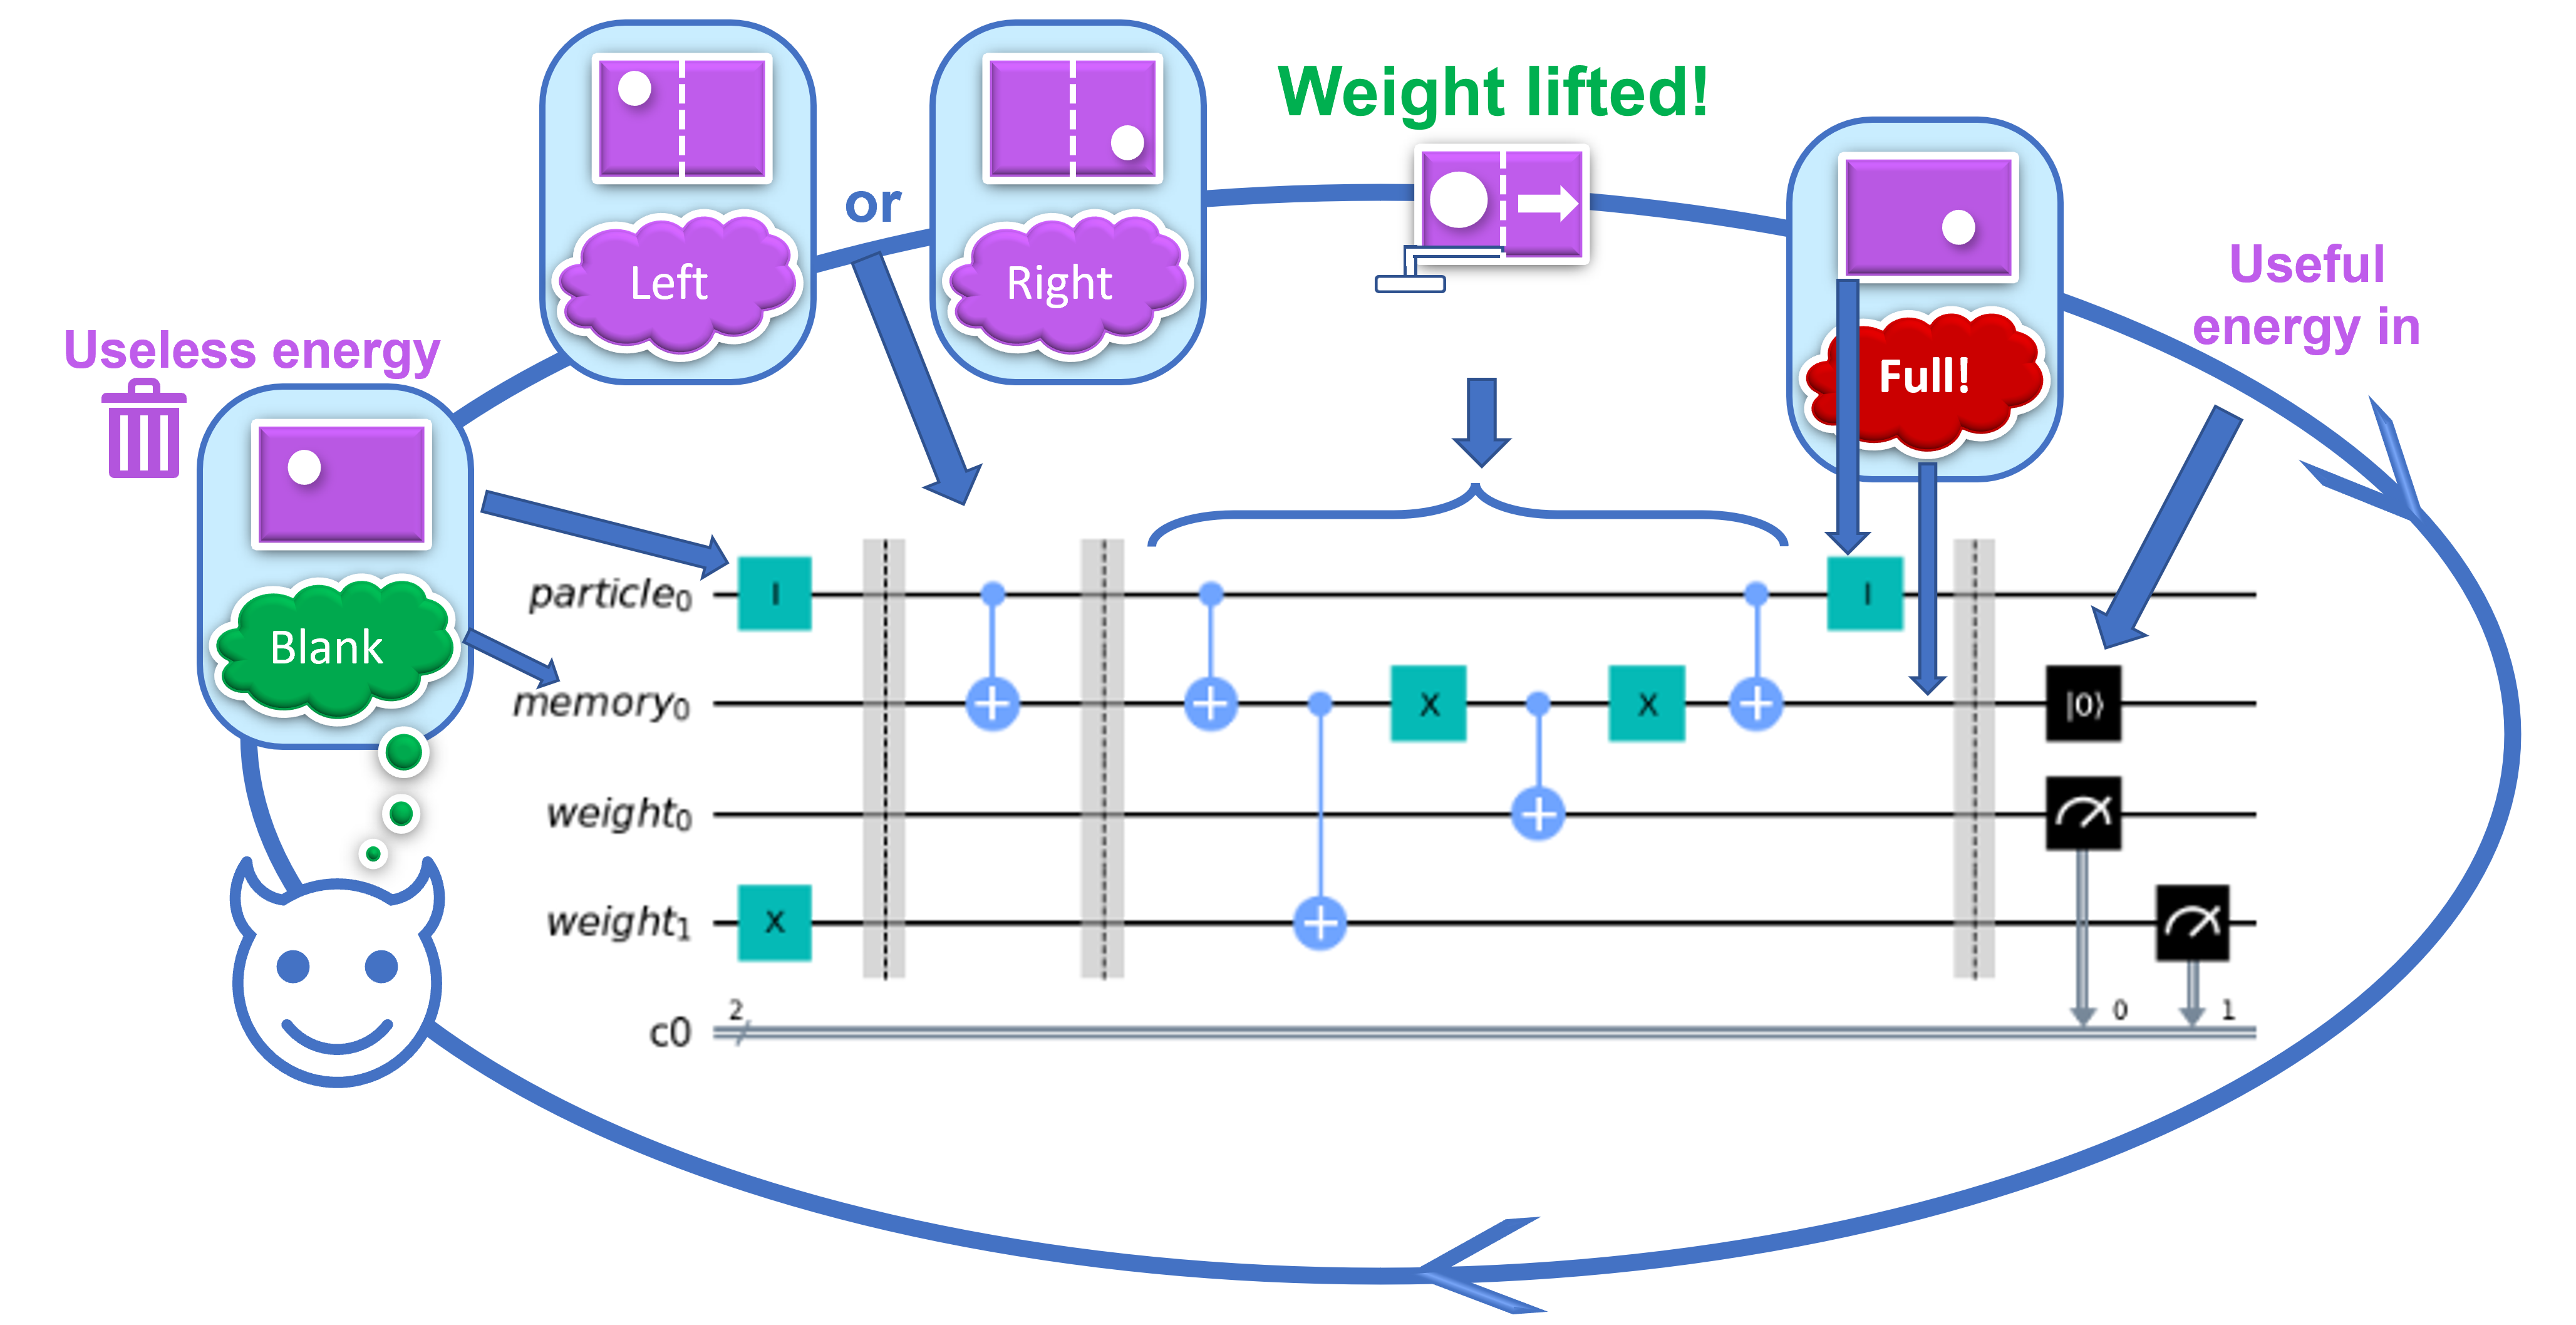

## Coding a quantum Szilard's Engine with Qiskit

Now let's code the circuit using Qiskit and try it out:

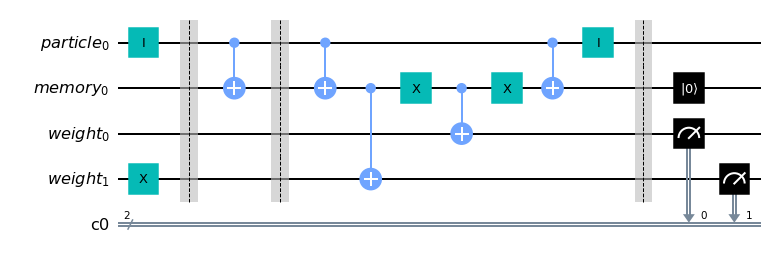

In [1]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.providers.aer.noise import NoiseModel

particle = QuantumRegister(1, "particle")
memory = QuantumRegister(1,"memory")
weight = QuantumRegister(2,"weight")
cr = ClassicalRegister(2)

engine = QuantumCircuit(particle, memory, weight,cr)

# Initialise particle as maximally mixed using noisy identity gate 
engine.id(0)

# Initialise weight 
engine.x(3)

engine.barrier()

# Demon measures particle
engine.cx(0,1) 
engine.barrier()

# Work extraction
engine.cx(0,1)
engine.cx(1,3)
engine.x(1)
engine.cx(1,2)
engine.x(1)
engine.cx(0,1)

engine.id(0) # Particle decorrelated from memory and demon

engine.barrier()

# Reset 
engine.reset(1)
engine.measure(2,0)
engine.measure(3,1)

engine.draw("mpl")

We need to add the noise to the Identity gates applied to the particle. We can do this using a noise model. Here our noise is added using a depolarizing channel, which maps any state to a maximally mixed state, essentially randomizing it. You can find out a summary of how to make a noise model in Qiskit in [this 1-Minute-Qiskit video.](https://www.youtube.com/watch?v=JGUPO9yf3h8&t=34s)

In [2]:
from qiskit.providers.aer import AerSimulator
from qiskit.tools.visualization import plot_histogram
from qiskit.providers.aer.noise import depolarizing_error

# Create an empty noise model
noise_model = NoiseModel()

# Add depolarizing error to all Identity gates on qubits 0 and 1
error = depolarizing_error(1, 1)
noise_model.add_quantum_error(error, ['id'], [0])
noise_model.add_quantum_error(error, ['id'], [1])

# Print noise model info

print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx']
  Instructions with noise: ['id']
  Qubits with noise: [0, 1]
  Specific qubit errors: [('id', [0]), ('id', [1])]


Now we run the circuit using a simulator to find out what happened to the weight!

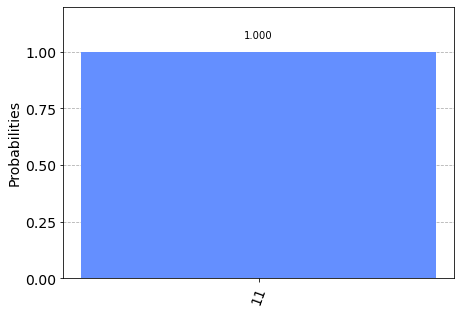

In [3]:
from qiskit.tools.visualization import plot_histogram
from qiskit.providers.aer import AerSimulator
from qiskit.tools.visualization import plot_histogram

from qiskit.test.mock import FakeVigo
device_backend = FakeVigo()

# Create noisy simulator backend

sim_noise = AerSimulator.from_backend(device_backend, noise_model = noise_model)

from qiskit.tools.visualization import plot_histogram

# Run and get counts

result = sim_noise.run(engine).result()

counts = result.get_counts(0)

# Plot noisy output
plot_histogram(counts)

We see that the weight is always lifted: the final state is always the high energy state, |11>, so the demon is able to successfully lift the weight every time the cycle is run. 

### Final state of particle 

Now let's check what state the particle ends up in. It should be back in a maximally mixed state, as it was in the beginning of the cycle. In the following circuit, we add the measurements to the particle qubit instead of the weight qubits, then run the circuit with the simulator to see the outcomes. 

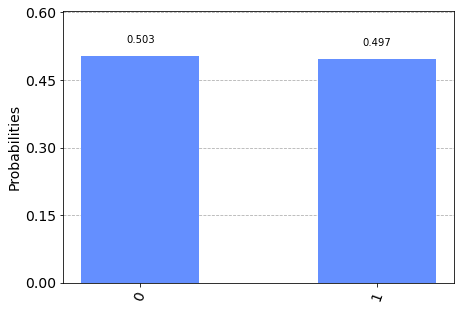

In [4]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.providers.aer.noise import NoiseModel

particle = QuantumRegister(1, "particle")
memory = QuantumRegister(1,"memory")
weight = QuantumRegister(2,"weight")
cr = ClassicalRegister(1)

engine = QuantumCircuit(particle, memory, weight,cr)

# Initialise particle as maximally mixed using noisy identity gate 
engine.id(0)

# Initialise weight 
engine.x(3)

engine.barrier()

# Demon measures particle
engine.cx(0,1) 
engine.barrier()

# Work extraction
engine.cx(0,1)
engine.cx(1,3)
engine.x(1)
engine.cx(1,2)
engine.x(1)
engine.cx(0,1)

engine.id(0) # Particle decorrelated from memory and demon

engine.barrier()

# Reset 
engine.reset(1)
engine.measure(0,0)

# Run and get counts

result = sim_noise.run(engine).result()

counts = result.get_counts(0)

# Plot noisy output
plot_histogram(counts)

The particle is measured to be 0 half the time and 1 half the time, which is consistent with it ending up in a maximally mixed state at the end of the cycle, as we expected. 

### Final state of memory

Now let's check what state the demon's memory ends up in at the end of the cycle. If the Reset operation has worked correctly, the memory should always end up in the |0> state at the end of the cycle, the same state that it started in. This is the blank memory state which enables the demon to correctly store information about the particle. 

Here we add the measurement to the demon's memory qubit and run the circuit with the simulator to see the outcome. 

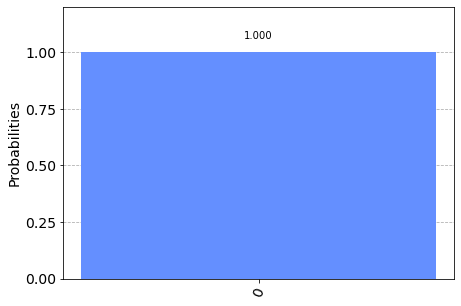

In [5]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.providers.aer.noise import NoiseModel

particle = QuantumRegister(1, "particle")
memory = QuantumRegister(1,"memory")
weight = QuantumRegister(2,"weight")
cr = ClassicalRegister(1)

engine = QuantumCircuit(particle, memory, weight,cr)

# Initialise particle as maximally mixed using noisy identity gate 
engine.id(0)

# Initialise weight 
engine.x(3)

engine.barrier()

# Demon measures particle
engine.cx(0,1) 
engine.barrier()

# Work extraction
engine.cx(0,1)
engine.cx(1,3)
engine.x(1)
engine.cx(1,2)
engine.x(1)
engine.cx(0,1)

engine.id(0) # Particle decorrelated from memory and demon

engine.barrier()

# Reset 
engine.reset(1)
engine.measure(1,0)

# Run and get counts

result = sim_noise.run(engine).result()

counts = result.get_counts(0)

# Plot noisy output
plot_histogram(counts)

The memory qubit always ends in the 0 state, as we expected. 

### What happens if we do not reset the memory?

Let's try and cheat the second law: can we get away with not including the Reset operation, which is the non-unitary operation that requires the entropy of the environment to increase? In the following circuit, I have created the circuit we get if we try and repeat the Szilard engine cycle without resetting the memory. 

If we do not reset the memory, then it ends the first cycle in a maximally mixed state. So the modified circuit below is the same as before, but with the memory starting in a maximally mixed state instead of the blank |0> state. As before, I prepare a maximally mixed state by adding an Identity gate, then using a noise model in Qiskit to implement a depolarizing noise channel. 

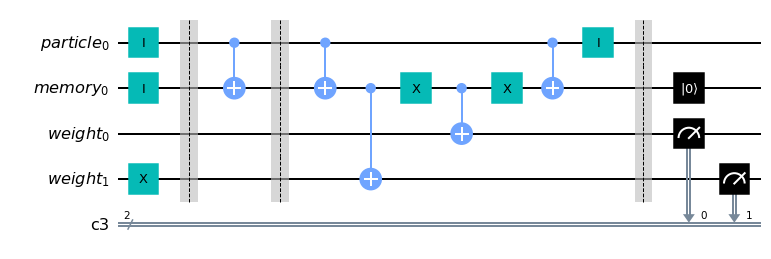

In [6]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.providers.aer.noise import NoiseModel

particle = QuantumRegister(1, "particle")
memory = QuantumRegister(1,"memory")
weight = QuantumRegister(2,"weight")
cr = ClassicalRegister(2)

engine = QuantumCircuit(particle, memory, weight,cr)

# Initialise particle as maximally mixed using noisy identity gate 
engine.id(0)

# Initialise weight 
engine.x(3)

# Initialise mixed memory 
engine.id(1)

engine.barrier()

# Demon measures particle
engine.cx(0,1) 
engine.barrier()

# Work extraction
engine.cx(0,1)
engine.cx(1,3)
engine.x(1)
engine.cx(1,2)
engine.x(1)
engine.cx(0,1)

engine.id(0) # Particle decorrelated from memory and demon

engine.barrier()

# Reset 
engine.reset(1)
engine.measure(2,0)
engine.measure(3,1)

engine.draw("mpl")

Now we can run the circuit with the simulator to find out what happens to weight with this modified circuit:

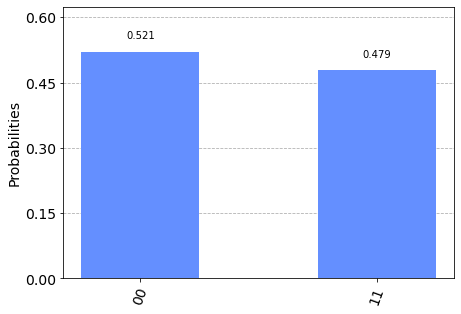

In [7]:
# Run and get counts

result = sim_noise.run(engine).result()

counts = result.get_counts(0)

# Plot noisy output
plot_histogram(counts)

Half the time the weight is lifted (|11>), but half the time the weight is lowered (|00>)! The demon can no longer reliably store information about the particle, because it does not start with a blank memory state. It ends up randomly placing the weight on some side of the box, which half the time is correct (weight is lifted), and half the time is wrong (weight lowered). So the demon is no longer able to reliably lift the weight. If we don't pay the entropy cost of doing a Reset operation, then we don't get to reliably lift the weight using information.  

## The cost of quantum erasure

So, how did our quantum Maxwell’s Demon pay the irreducible entropy cost of erasure—the cost that is demanded by Landauer’s principle, and which enabled Charlie Bennett to save the second law of thermodynamics from being violated? 
The standard measure of entropy of classical information is Shannon entropy, which is calculated based on the probabilities of each possible outcome. A coin with 50% chance of Heads and 50% chance of Tails has maximum Shannon entropy. A coin that has 100% chance of Heads has 0 Shannon entropy. 

The quantum generalisation of this is the von Neumann entropy, calculated using the density matrix of the qubit. For maximally mixed states, the von Neumann entropy is maximum, like the random coin. For pure states like |0⟩ and |+⟩, the von Neumann entropy is 0. 

For the demon’s memory to be erased, it needs to transform from a maximally mixed state to a |0⟩ state. All quantum interactions are reversible and unitary, which means that the overall von Neumann entropy is never changed. For the von Neumann entropy of the demon’s memory to decrease, the entropy of the environment that erases it must increase by the same amount. This means that like classical erasure, quantum erasure has a minimum entropy cost.

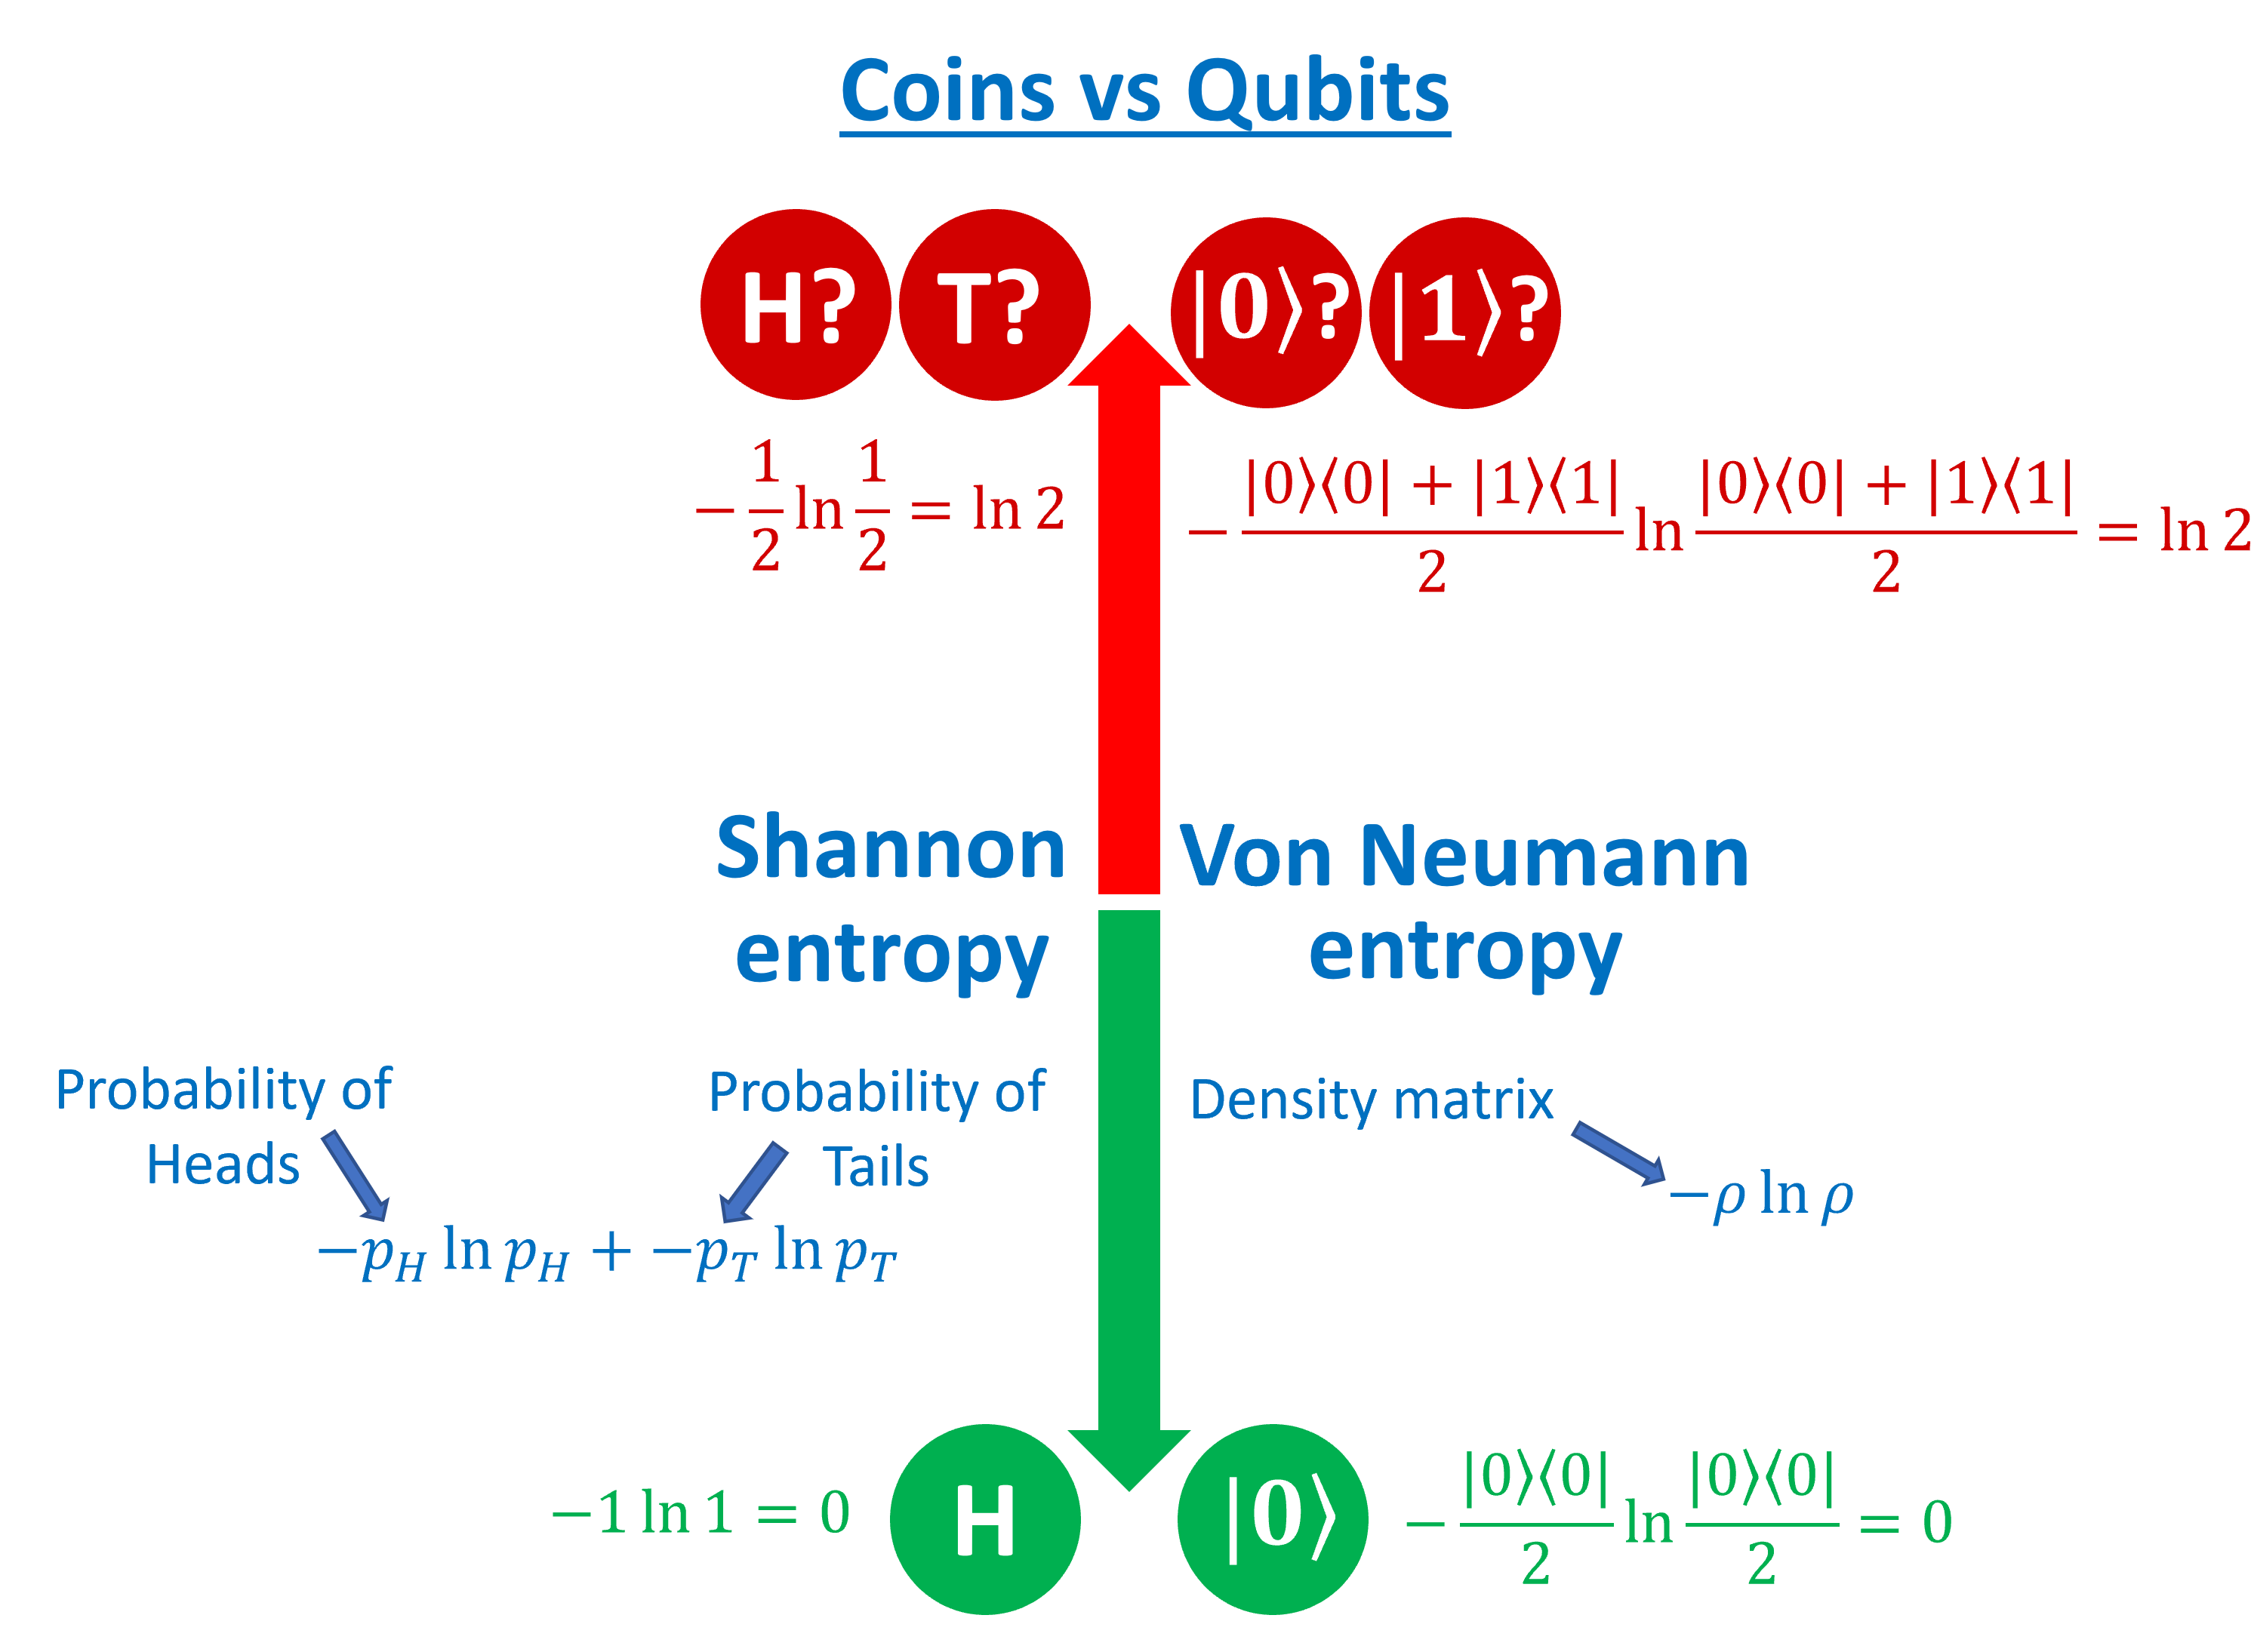

### Coding quantum erasure using Qiskit

Until now we have modelled the erasure of the demon's memory qubit using a Reset operation. To see why the Reset operation causes a minimum entropy increase in the environment, we need to instead model the Resetting process using unitary, reversible gates, by modelling the environment explicitly as a seperate system. 

So here I have created a circuit to demonstrate the simplest possible version of the Resetting process. The environment starts in a low entropy, |0> state, and the memory starts in a high entropy, maximally mixed state. Then I apply a SWAP gate between the memory and environment. After the SWAP gate, the memory is now in the |0> state, so the memory has been successfully reset. However, the environment ends up in the maximally mixed state. 

We can quantify the entropy of quantum states using the [von Neumann entropy.](https://qiskit.org/documentation/stubs/qiskit.quantum_info.entropy.html). The von Neumann entropy of the blank |0> state is 0, and of the maximally mixed state is the highest it can be! Therefore the environment's entropy has had to increase for the Reset operation to be implemented on the memory. 

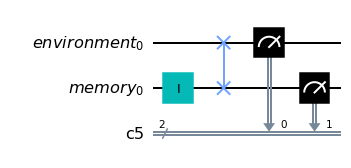

In [9]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.providers.aer.noise import NoiseModel

environment = QuantumRegister(1, "environment")
memory = QuantumRegister(1,"memory")

cr = ClassicalRegister(2)

reset_circ = QuantumCircuit(environment, memory, cr)

# Initialise memory as maximally mixed using noisy identity gate 
reset_circ.id(1)

# Swap environment and memory 
reset_circ.swap(0,1)

reset_circ.measure([0,1],[0,1])

reset_circ.draw("mpl")


We can run the circuit with the simulator to check the states that the environment and memory end up in:

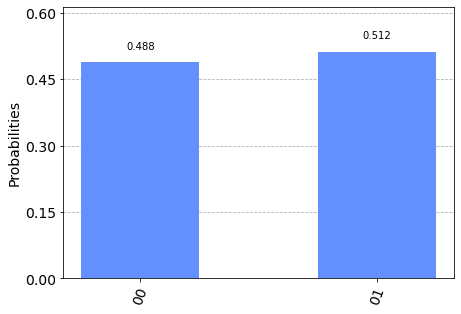

In [10]:
# Run and get counts

result = sim_noise.run(reset_circ).result()

counts = result.get_counts(0)

# Plot noisy output
plot_histogram(counts)

As expected, the environment is now |0> half the time and |1> half the time, while the memory has been successfully reset to |0>. 

Remember to check out the [Qiskit video](https://youtu.be/YX5VxYvDfxM) and [blog post](https://medium.com/qiskit) for more background on the quantum Maxwell's Demon thought experiment. Let us know in the video comments if you think the demon has been exorcised for good - or if it will be back to haunt the foundations of thermodynamics with Tricks and Treats for many years to come...!